In [157]:
import numpy as np

from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms as T

In [158]:
transform = {"train": T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.4914, 0.44822, 0.4465], [0.247, 0.243, 0.261]),
                        T.RandomAffine(degrees=10, translate=(0.1, 0.1)),
                        T.RandomHorizontalFlip()
                      ]),
             "test": T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.4914, 0.44822, 0.4465], [0.247, 0.243, 0.261])
                      ])}

data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform["train"])
data_train, data_valid = torch.utils.data.random_split(data_train, (45000, 5000))
data_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform["test"])

Files already downloaded and verified
Files already downloaded and verified


In [159]:
batch_size = 256

loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=False, num_workers=2)
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, shuffle=False, num_workers=2)
loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [160]:
def softmax(x):
    x = x - np.max(x, axis=0, keepdims=True)
    ex = np.exp(x)
    return ex / np.sum(ex, axis=0, keepdims=True)

def negative_log_likelihood(yhat, y, eps=1e-9):
    return -np.sum(y * np.log(yhat + eps)) / y.shape[1]

class ReLU:
    x = None
    
    def forward(self, x):
        self.x = x
        y = np.maximum(x, 0)
        return y

    def backward(self, dldy):
        # Note that the jacobian is a diagonal matrix, since ReLU is applied elementwise
        # we can thus simply express the jacobian as the diagonal vector
        dydx = self.x > 0  # (one where x > 0, else 0)
        dldx = dldy * dydx  # chain rule
        return dldx


class MultinomialCrossEntropyLoss:
    y, yhat = None, None

    def forward(self, logits, y):
        self.y = y
        self.yhat = softmax(logits)
        return negative_log_likelihood(self.yhat, y)

    def backward(self):
        dldlogits = (self.yhat - self.y) / self.y.shape[1]
        return dldlogits

In [161]:
class MLP():
    def __init__(self, hidden_neurons = 100, input_shape = 32*32*3, output_shape = 10):

        # Weights and biases
        b = np.sqrt(1 / input_shape)
        self.W1 = np.random.uniform(-b, b, size=(hidden_neurons, input_shape)).astype(np.float32)
        self.b1 = np.random.uniform(-b, b, size=(hidden_neurons, 1)).astype(np.float32)

        b = np.sqrt(1 / hidden_neurons)
        self.W2 = np.random.uniform(-b, b, size=(output_shape, hidden_neurons)).astype(np.float32)
        self.b2 = np.random.uniform(-b, b, size=(output_shape, 1)).astype(np.float32)
        
        # Placeholders for their gradients
        self.dldW1, self.dldb1, self.dldW2, self.dldb2 = None, None, None, None

        # Activations and hiddens/outputs to be computed in forward() and to be used in backward()
        self.x, self.h = None, None

        # Activation function for hidden layer
        self.relu = ReLU()

    def forward(self, x):
        self.x = x
        a1 = self.W1 @ x.T + self.b1
        self.h = self.relu.forward(a1)
        logits = self.W2 @ self.h + self.b2
        return logits
    
    def backward(self, y):
        self.dldW2 = y @ self.h.T
        self.dldb2 = np.sum(y, axis=1).reshape((-1, 1))
        dlda1 = self.relu.backward((y.T @ self.W2).T)
        self.dldW1 = dlda1 @ self.x
        self.dldb1 = np.sum(dlda1, axis = 1).reshape((-1, 1))

In [162]:
def convert_input(x):
  return x.numpy().reshape((-1, 32*32*3))

def convert_output(y, classes = 10):
  return np.eye(classes)[y.numpy()]

In [163]:
# initialization
mlp = MLP(256)
loss_fun = MultinomialCrossEntropyLoss()

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# mini batch gradient descent
lr = 2.5e-2
epoches = 200

for epoch in tqdm(range(epoches)):

    # Train part

    epoch_losses = []
    correct = 0

    for x, y in loader_train:
    
        # Do the numpy stuff here, dirty and quick
        x, y = convert_input(x), convert_output(y)

        # Forward
        logits = mlp.forward(x)

        # Get the training loss for the batch
        loss = loss_fun.forward(logits, y.T)

        # Get the classification-rate for the batch
        loss_grad = loss_fun.backward()

        # Perform backpropagation
        mlp.backward(loss_grad)

        # Update network
        mlp.W1 -= lr * mlp.dldW1
        mlp.W2 -= lr * mlp.dldW2
        mlp.b1 -= lr * mlp.dldb1
        mlp.b2 -= lr * mlp.dldb2

        # Update epoch losses and accuracy
        epoch_losses.append(loss)
        correct += np.sum(np.argmax(logits, axis=0) == np.argmax(y.T, axis=0))
    
    train_losses.append(np.mean(epoch_losses))
    train_accuracies.append(correct/45000)

    # Validation part

    epoch_losses = []
    correct = 0

    for x, y in loader_valid:
        
        # Do the numpy stuff here, dirty and quick
        x, y = convert_input(x), convert_output(y)

        # Forward
        logits = mlp.forward(x)

        # Get the training loss for the batch
        loss = loss_fun.forward(logits, y.T)

        # Update epoch losses and accuracy
        epoch_losses.append(loss)
        correct += np.sum(np.argmax(logits, axis=0) == np.argmax(y.T, axis=0))
    
    valid_losses.append(np.mean(epoch_losses))
    valid_accuracies.append(correct/5000)


  0%|          | 0/200 [00:00<?, ?it/s]

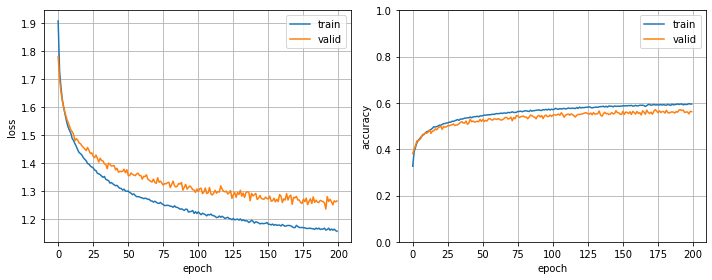

In [166]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(valid_accuracies, label='valid')
plt.ylim(0, 1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [165]:
correct = 0
epoch_losses = []

for x, y in loader_test:
    
    # Do the numpy stuff here, dirty and quick
    x, y = convert_input(x), convert_output(y)

    # Forward
    logits = mlp.forward(x)

    # Get the training loss for the batch
    loss = loss_fun.forward(logits, y.T)

    # Update epoch losses and accuracy
    epoch_losses.append(loss)
    correct += np.sum(np.argmax(logits, axis=0) == np.argmax(y.T, axis=0))

test_loss = np.mean(epoch_losses)
correct = correct/10000

print("Correct : ", correct, " \tLoss : ", test_loss)


Correct :  0.5881  	Loss :  1.1761944492836858
